In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
from geopy.distance import geodesic
import OLCdistance as olc

In [11]:
def parse_trackpoint(line):
    # Extract components from the line
    time_utc = line[1:7]  # HHMMSS
    latitude_raw = line[7:15]  # DDMMmmmN
    longitude_raw = line[15:24]  # DDDMMmmmE
    gps_altitude = int(line[25:30])  # GGGG
    pressure_altitude = int(line[30:35])  # LLLL

    # Convert UTC time
    hours = int(time_utc[:2])
    minutes = int(time_utc[2:4])
    seconds = int(time_utc[4:6])

    # Convert latitude to decimal degrees
    latitude_deg = int(latitude_raw[:2])
    latitude_min = float(latitude_raw[2:7]) / 1000
    latitude = latitude_deg + latitude_min / 60
    if latitude_raw[7] == 'S':
        latitude *= -1

    # Convert longitude to decimal degrees
    longitude_deg = int(longitude_raw[:3])
    longitude_min = float(longitude_raw[3:8]) / 1000
    longitude = longitude_deg + longitude_min / 60
    if longitude_raw[8] == 'W':
        longitude *= -1

    return {
        "time": f"{hours:02}:{minutes:02}:{seconds:02}",
        "latitude": latitude,
        "longitude": longitude,
        "gps_altitude_m": gps_altitude,
        "pressure_altitude_m": pressure_altitude,
    }

In [12]:
file_name = "2024-05-19 10_05_00.igc"
# file_name = "2018-07-16 09_13_56.igc"

with open(file_name, 'r') as file:
    lines = file.readlines()

flight_data = [line for line in lines if line.startswith('B')]
records = [parse_trackpoint(line) for line in flight_data]

df = pd.DataFrame(records)

for i in range(1, len(df)-1):
    if i % 20 > 0:
        df = df.drop([i])

flight_loginterval = int(df["time"].iloc[1][-2:]) - \
    int(df["time"].iloc[0][-2:])
df.head()

,time,latitude,longitude,gps_altitude_m,pressure_altitude_m
0,10:05:00,40.031200,32.328300,1090,1144
20,10:05:20,40.031250,32.328017,1083,1136
40,10:05:40,40.031817,32.326683,1080,1131
60,10:06:00,40.032917,32.325683,1088,1139
80,10:06:20,40.032300,32.326400,1107,1160


In [13]:
prev_coord = None


def calculate_distance(df):
    global prev_coord
    if prev_coord is None:
        prev_coord = (df["latitude"], df["longitude"])
        return 0
    coord1 = (df["latitude"], df["longitude"])
    coord2 = prev_coord
    prev_coord = coord1
    return geodesic(coord1, coord2).meters


prev_total_distance = 0


def caluculate_total_distance(row):
    global prev_total_distance
    prev_total_distance += row["distance_m"]
    return prev_total_distance


start_loc = (df["latitude"].iloc[0], df["longitude"].iloc[0])


def calculate_distance_from_start(row):
    coord = (row["latitude"], row["longitude"])
    return geodesic(start_loc, coord).meters


df["distance_m"] = df.apply(calculate_distance, axis=1)
df["total_distance_m"] = df.apply(caluculate_total_distance, axis=1)
df["climb_m"] = df["gps_altitude_m"].diff()
df["climb_rate_m/s"] = df["climb_m"] / flight_loginterval
df["speed_km/s"] = (df["distance_m"]/1000) / (flight_loginterval/3600)
df["distance_from_start_m"] = df.apply(calculate_distance_from_start, axis=1)
df["gps_points"] = df.apply(lambda row: (row["latitude"], row["longitude"]), axis=1)
df.head()

,time,latitude,longitude,gps_altitude_m,pressure_altitude_m,distance_m,total_distance_m,climb_m,climb_rate_m/s,speed_km/s,distance_from_start_m,gps_points
0,10:05:00,40.031200,32.328300,1090,1144,0.000000,0.000000,NaN,NaN,0.000000,0.000000,"(40.0312, 32.3283)"
20,10:05:20,40.031250,32.328017,1083,1136,24.812964,24.812964,-7.0,-0.35,4.466333,24.812964,"(40.03125, 32.32801666666667)"
40,10:05:40,40.031817,32.326683,1080,1131,130.041330,154.854294,-3.0,-0.15,23.407439,154.044144,"(40.031816666666664, 32.326683333333335)"
60,10:06:00,40.032917,32.325683,1088,1139,149.007066,303.861360,8.0,0.40,26.821272,293.622788,"(40.032916666666665, 32.32568333333333)"
80,10:06:20,40.032300,32.326400,1107,1160,91.815714,395.677074,19.0,0.95,16.526829,203.022195,"(40.0323, 32.3264)"


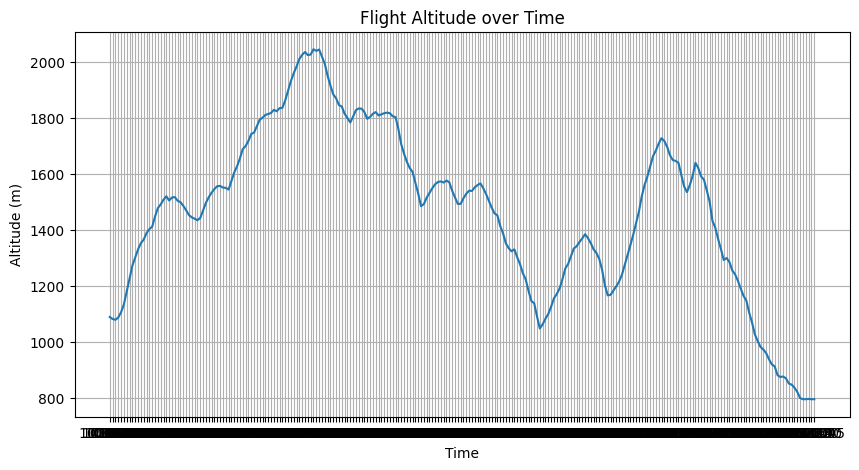

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['gps_altitude_m'])
plt.xlabel('Time')
plt.ylabel('Altitude (m)')
plt.title('Flight Altitude over Time')
plt.grid(True)
plt.show()

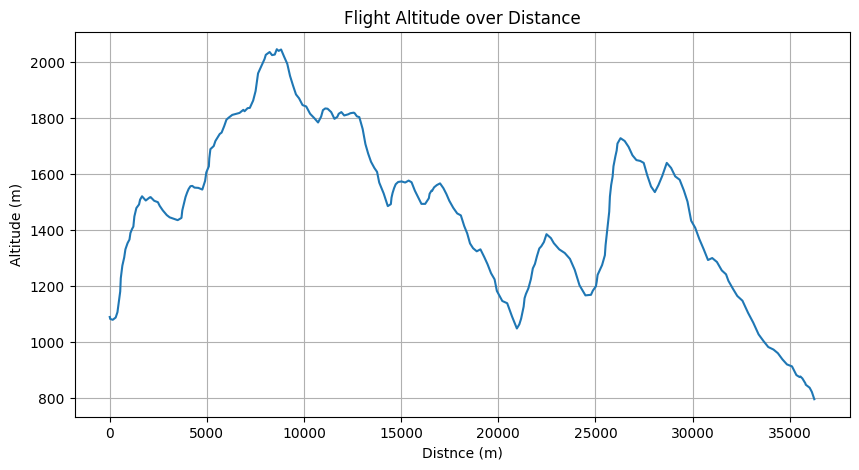

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df['total_distance_m'], df['gps_altitude_m'])
plt.xlabel('Distnce (m)')
plt.ylabel('Altitude (m)')
plt.title('Flight Altitude over Distance')
plt.grid(True)
plt.show()

In [16]:
coordinates = list(zip(df["latitude"], df["longitude"]))
map = fm.Map(location=coordinates[0], zoom_start=13)
for coord in coordinates:
    fm.CircleMarker(location=coord, radius=1, color='blue',
                    fill=True, fill_color='blue', popup="Point").add_to(map)
map.save("map.html")

In [17]:
time_difference = str(pd.to_datetime(
    df['time'].iloc[-1]) - pd.to_datetime(df['time'].iloc[0]))
sonuc = (
    f"Toplam mesafe: {df['total_distance_m'].iloc[-1]/1000:.1f} km.\n"
    f"Maksimum yükseklik: {df['gps_altitude_m'].max()} m.\n"
    f"Maksimum tırmanma hızı: {df['climb_rate_m/s'].max()} m/s.\n"
    f"Maksimum iniş hızı: {df['climb_rate_m/s'].min()} m/s.\n"
    f"Maksimum Uzaklık: {df['distance_from_start_m'].max()/1000:.1f} km.\n"
    f"Ortalama hız: {df['speed_km/s'].mean():.1f} km/s.\n"
    f"Maksimum hız: {df['speed_km/s'].max():.1f} km/s.\n"
    f"Toplam süre: {time_difference.split()[2]}\n"
    f"Maksimum İrtifa: {df['gps_altitude_m'].max()} m.\n"
    f"Minimum İrtifa: {df['gps_altitude_m'].min()} m.\n"
    f"Kalkış İrtifası: {df['gps_altitude_m'].iloc[0]} m.\n"
)


print(sonuc)
df.to_csv("flight_data.csv", index=False)

Toplam mesafe: 36.3 km.
Maksimum yükseklik: 2044 m.
Maksimum tırmanma hızı: 2.7 m/s.
Maksimum iniş hızı: -3.4 m/s.
Maksimum Uzaklık: 6.8 km.
Ortalama hız: 26.1 km/s.
Maksimum hız: 54.9 km/s.
Toplam süre: 01:22:45
Maksimum İrtifa: 2044 m.
Minimum İrtifa: 797 m.
Kalkış İrtifası: 1090 m.



In [ ]:
gps_points = list(zip(df['latitude'].values.tolist(), df['longitude'].values.tolist()))
distance, triangle = olc.fai_olc_distance(gps_points)
print(f"Maximum FAI OLC Distance: {distance:.2f} km")
print(f"Triangle Points: {triangle}")


Maximum FAI OLC Distance: 16.60 km
Triangle Points: ((40.04013333333333, 32.334383333333335), (40.03395, 32.25065), (40.00963333333333, 32.29703333333333))
